In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageTk
import os
import glob 
import pickle
import torch
from torchvision import transforms, io, models
from torchvision.models.feature_extraction import create_feature_extractor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import neptune.new as neptune
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM
from sklearn.model_selection import train_test_split

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Computation resource: {device}')

Computation resource: cuda


In [17]:
path_to_img = 'C:/Users/Benjamin/Documents/PDLW/VOCtrainval_06-Nov-2007/JPEGImages'

# step 1:
* bulling on the fly dataset for the model
* showing sample of the data we created
* creating data loader

In [75]:
def show_images(images, text,epoch_num, save):
    # Create a figure with subplots
    fig, axs = plt.subplots(nrows=1, ncols=len(text), figsize=(5, 10))
    fig.set_size_inches(10,10)

    # Set the distance between the subplots
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # Display each image
    for i, image in enumerate(images):
        image *= 255
        if isinstance(image, Image.Image):
            axs[i].imshow(image)
            axs[i].set_title("Image ({}x{})".format(image.width, image.height))
        elif isinstance(image, np.ndarray) | isinstance(image, torch.Tensor):
            # image = image.cpu().detach().numpy()
            image = image.cpu().detach()
            # axs[i//2, i%2].imshow(np.transpose(image,(1,2,0)))
            axs[i].imshow(image.permute(1,2,0))
            # axs[i//2, i%2].set_title(f"{text[i]} image ({image.shape[1]}x{image.shape[1]})")
            axs[i].set_title(f"{text[i]} image ({image.shape[1]}x{image.shape[1]})")
            if i%2 == 1 and epoch_num != None:
                axs[i].text(2, 10, f'epoch:{epoch_num}', fontsize=10)
    # Show the plot
    plt.show()
    if save:
        # save the fig
        fig.savefig(f'C:/Users/Benjamin/Documents/PDLW/val_img/{epoch_num}.png',bbox_inches='tight')
        #Creating an Animation
        
def make_gif(frame_folder, gif_name):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save(f'{gif_name}.gif', format="GIF", append_images=frames,
    save_all=True, duration=800, loop=0)

In [115]:
frame_folder = 'C:/Users/Benjamin/Documents/PDLW/val_img/'
make_gif(frame_folder, 'model_0')

In [19]:
# reading all images path
img_paths = glob.glob(f'{path_to_img}/*')
train_path, val_path = train_test_split(img_paths, test_size=0.2, random_state=42, shuffle=True)
# train_path, val_path = train_test_split(train_path, test_size=0.1, random_state=42, shuffle=True)
print('number of images in train set: ' ,len(train_path), '\nnumber of images in validation set: ', len(val_path)) 

number of images in train set:  4008 
number of images in validation set:  1003


In [20]:
class SuperResolutionDataset(Dataset):
    def __init__(self, img_paths, low_res_size=(72,72), mid_res_size=(144,144),large_res_size=None):
        self.img_paths = img_paths
        self.large_res_size = large_res_size
        self.transformLow = transforms.Compose([
            transforms.Resize(low_res_size),
            transforms.ToTensor()
        ])
        self.transformMid = transforms.Compose([
            transforms.Resize(mid_res_size),
            transforms.ToTensor()
        ])
        if large_res_size != None:
            self.transformLarge = transforms.Compose([
                transforms.Resize(large_res_size),
                transforms.ToTensor()
            ])
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        high_res_img = Image.open(self.img_paths[idx])
        X = self.transformLow(high_res_img)
        X /= 255
        y_mid =  self.transformMid(high_res_img)
        if self.large_res_size == None:
            y_mid /= 255
            return X, y_mid
        else:
            y_large =  self.transformLarge(high_res_img)
            y_mid /= 255 
            y_large /= 255
            return X, y_mid, y_large

### presenting sample from PascalVOC 2007 dataset 

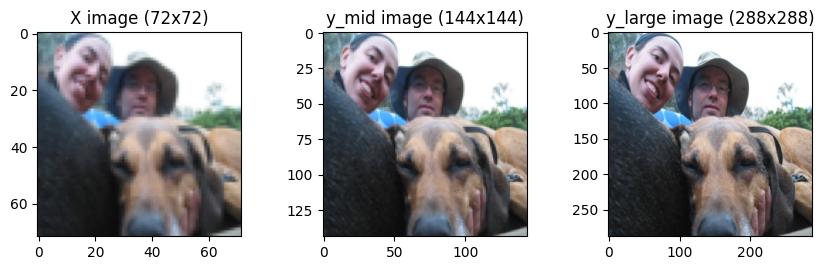

In [88]:
images = SuperResolutionDataset(train_path, large_res_size=(288,288))
X, y_mid, y_large = images.__getitem__(0)
show_images([X, y_mid, y_large],['X', 'y_mid', 'y_large'],None,save=False)

# step 2:
* creating super resolution model with one output of higher resolution image (144X144)
* training the model

In [27]:
class SuperResolutionModel1(nn.Module):
    def __init__(self, num_channels=3, upsample_factor=2):
        super(SuperResolutionModel1, self).__init__()
        self.num_channels = num_channels
        self.upsample_factor = upsample_factor  
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same')
        self.upsample = nn.Upsample(scale_factor=upsample_factor, mode='bilinear')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, padding='same')

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        return x

In [28]:
def accuracy_metrics(y_ture, y_pred):
    y_ture, y_pred = y_ture.cpu().detach().numpy(), y_pred.cpu().detach().numpy()
    psnr = PSNR(y_ture, y_pred, data_range=1.0)
    return psnr

def train_loop(data_loader, model,device,loss_fn,optimizer,print_every_n=200):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss=0
    total_psnr = 0
    for batch,(X,y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        psnr = accuracy_metrics(y, pred)
        total_psnr += psnr
        
        loss, current = loss.item(), batch*len(X)
        if batch%print_every_n==0:
            print(f'training loss={loss:.3f}, {current} / {size}')

    train_loss /= num_batches
    total_psnr /=size  

    return train_loss, total_psnr

def validation_loop(data_loader,model,device,loss_fn,epoch_num):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    val_loss=0
    total_psnr = 0
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred,y).item()
            psnr = accuracy_metrics(y, pred)
            total_psnr += psnr

    val_loss /= num_batches
    total_psnr /=size                
    show_images([y[0],pred[0]],['Ground truth','pred'], epoch_num, save=True)
    print(f'val_PSNR = {total_psnr}, val_loss = {val_loss:2f}')
    return val_loss, total_psnr

In [36]:
batch_size = 10
train_loader = DataLoader(SuperResolutionDataset(train_path), shuffle=False, batch_size=batch_size)
validation_loader = DataLoader(SuperResolutionDataset(val_path), shuffle=False, batch_size=batch_size)
lr = 0.001
epochs = 25
patience = 25
model = SuperResolutionModel1()
model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True
        

In [ ]:
params = {"batch_size": batch_size,
            "learning_rate": lr, 
            "criterion": "MAE",
            "optimizer": 'Adam'}
run = neptune.init(
    project="sayab/assignment-3",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentials
run["architecture"] = "SuperResolutionModel1"
run["parameters"] = params

results = []
early_stopping_counter = 0
best_loss = 10000
# define the number of epochs and early stopping patience
for epoch in range(epochs):
    print(f'current epoch: {epoch+1}')
    start_time = time.time()
    train_loss, train_psnr = train_loop(train_loader, model, device, criterion, optimizer)
    total_train_time = (time.time() - start_time)/60

    run["train/psnr"].log(train_psnr)
    run["train/loss"].log(train_loss)
    run['train/run_time'].log(total_train_time)

    val_loss, val_psnr = validation_loop(validation_loader, model, device, criterion, epoch_num=epoch)
    run["validation/psnr"].log(val_psnr)
    run["validation/loss"].log(val_loss)   
    results.append({'epoch_number':epoch,'train_loss':train_loss,'val_loss':val_loss,'train_psnr':train_psnr,'val_psnr':val_psnr,
    'train_time':total_train_time})
    
    if val_loss < best_loss:
    # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
        # torch.save(model.state_dict(), f'model_{epoch}.pth')
        best_loss = val_loss
        early_stopping_counter = 0
    # otherwise, increment the early stopping counter
    else:
        early_stopping_counter += 1     
    # if the early stopping counter has reached the patience, stop training
    if early_stopping_counter == patience:
        break
run.stop()

### model performance over epochs

![model_1.1](model_1.gif)

# Step 3
* create super resolution model as before and in addition add another upsmaling layer to get another out of higher resolution (288X288)
* train the model 

In [37]:
class SuperResolutionModel2(nn.Module):
    def __init__(self, num_channels=3, upsample_factor=2):
        super(SuperResolutionModel2, self).__init__()
        self.num_channels = num_channels
        self.upsample_factor = upsample_factor  
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same')
        self.upsample = nn.Upsample(scale_factor=upsample_factor, mode='bilinear')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, padding='same')   # mid output layer 
        self.upsample2 = nn.Upsample(scale_factor=upsample_factor, mode='bilinear')        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, padding='same')   # large output layer 

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.upsample(x)
        mid_out = self.conv3(x)
        x = self.upsample(x)
        large_put = self.conv4(x)
        return mid_out, large_put

In [71]:
def train_loop2(data_loader, model,device,loss_fn,optimizer,print_every_n=200):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss = 0
    total_psnr = 0
    for batch,(X,y_mid, y_large) in enumerate(data_loader):
        X,y_mid, y_large = X.to(device), y_mid.to(device) , y_large.to(device)
        pred_mid, pred_large = model(X)
        loss = loss_fn(pred_mid, y_mid)
        loss += loss_fn(pred_large, y_large)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        psnr = accuracy_metrics(y_mid, pred_mid)
        psnr += accuracy_metrics(y_large, pred_large) 
        total_psnr += psnr
        
        loss, current = loss.item(), batch*len(X)
        if batch%print_every_n==0:
            print(f'training loss={loss:.3f}, {current} / {size}')

    train_loss /= num_batches
    total_psnr /=size  

    return train_loss, total_psnr

def validation_loop2(data_loader,model,device,loss_fn, epoch_number):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    val_loss=0
    total_psnr = 0
    with torch.no_grad():
        for batch,(X,y_mid, y_large) in enumerate(data_loader):
            X, y_mid, y_large = X.to(device), y_mid.to(device) , y_large.to(device)
            pred_mid, pred_large = model(X)
            loss = loss_fn(pred_mid, y_mid)
            loss += loss_fn(pred_large, y_large)
            val_loss += loss
            psnr = accuracy_metrics(y_mid, pred_mid) 
            psnr += accuracy_metrics(y_large, pred_large)
            total_psnr += psnr

    val_loss /= num_batches
    total_psnr /=size                
    show_images([X[0],pred_mid[0], pred_large[0]],['X','pred', 'pred'],epoch_number, save=True)
    print(f'val_PSNR = {total_psnr}, val_loss = {val_loss:2f}')
    return val_loss, total_psnr

In [65]:
def training(params, architecture, model, epochs, patience, criterion,optimizer, batch_size, train_loader, validation_loader): 
    run = neptune.init(
        project="sayab/assignment-3",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
    )  # your credentials
    run["architecture"] = architecture
    run["parameters"] = params

    early_stopping_counter = 0
    best_loss = 10000
    # define the number of epochs and early stopping patience
    for epoch in range(epochs):
        print(f'current epoch: {epoch+1}')
        start_time = time.time()
        train_loss, train_psnr = train_loop2(train_loader, model, device, criterion, optimizer)
        total_train_time = (time.time() - start_time)/60

        run["train/psnr"].log(train_psnr)
        run["train/loss"].log(train_loss)
        run['train/run_time'].log(total_train_time)

        val_loss, val_psnr = validation_loop2(validation_loader, model, device, criterion, epoch)
        run["validation/psnr"].log(val_psnr)
        run["validation/loss"].log(val_loss)
        if val_loss < best_loss:
        # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
            # torch.save(model.state_dict(), f'model_{epoch}.pth')
            best_loss = val_loss
            early_stopping_counter = 0
        # otherwise, increment the early stopping counter
        else:
            early_stopping_counter += 1     
        # if the early stopping counter has reached the patience, stop training
        if early_stopping_counter == patience:
            break
    run.stop()

In [62]:
batch_size = 10
train_loader = DataLoader(SuperResolutionDataset(train_path,large_res_size=(288,288)), shuffle=False, batch_size=batch_size)
validation_loader = DataLoader(SuperResolutionDataset(val_path,large_res_size=(288,288)), shuffle=False, batch_size=batch_size)
lr = 0.0001
epochs = 50
patience = 10
model = SuperResolutionModel2()
model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True
params = {"batch_size": batch_size,
            "learning_rate": lr, 
            "criterion": "MAE",
            'weighted loss': 'large X 2 , mide X 1',
            'max epochs': epochs,
            'patience': patience}
architecture = "SuperResolutionModel2"
training(params, architecture, model, epochs, patience, criterion,optimizer, batch_size, train_loader, validation_loader)
            

# step 4
* adding residual block 

In [78]:
class SuperResolutionModel3(nn.Module):
    def __init__(self, num_channels=3, upsample_factor=2, relu_slope_factor=0):
        super(SuperResolutionModel3, self).__init__()
        self.num_channels = num_channels
        self.upsample_factor = upsample_factor 
        self.relu = nn.LeakyReLU(negative_slope=relu_slope_factor, inplace=False)
        self.upsample = nn.Upsample(scale_factor=upsample_factor, mode='nearest')
        # residual block 1
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding='same')
        # residual block 2
        self.conv3 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding='same')
        self.conv_mid_out = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, padding='same')
        # residual block 3
        self.conv5 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, padding='same')
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding='same')
        self.conv_large_out = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, padding='same')


    def forward(self, x):
        # residual block 1
        x1 = self.conv1(x)
        x1 = self.conv2(x1)
        x = torch.add(x,x1)
        x = self.relu(x)
        # residual block 2
        x1 = self.conv3(x)
        x1 = self.conv4(x1)
        x = torch.add(x,x1)
        x = self.relu(x)
        x = self.upsample(x)
        mid_out = self.conv_mid_out(x)
        # residual block 3 
        x1 = self.conv5(x)
        x1 = self.conv6(x1)
        x = torch.add(x,x1)
        x = self.relu(x)
        x = self.upsample(x)
        large_out = self.conv_large_out(x)
        return mid_out, large_out

In [ ]:
batch_size = 10
train_loader = DataLoader(SuperResolutionDataset(train_path,large_res_size=(288,288)), shuffle=False, batch_size=batch_size)
validation_loader = DataLoader(SuperResolutionDataset(val_path,large_res_size=(288,288)), shuffle=False, batch_size=batch_size)
lr = 0.001
epochs = 15
patience = 5
relu_slope_factor = 0
model = SuperResolutionModel3(relu_slope_factor=relu_slope_factor)
model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "criterion": "MAE",
        "LeakyReLU":relu_slope_factor,
        'max epochs': epochs,
        'patience': patience,
        }
        
architecture = "SuperResolutionModel4"
training(params, architecture, model, epochs, patience, criterion,optimizer, batch_size, train_loader, validation_loader)

# step 5 
* change the add function in residual block to concatenation 

In [84]:
class SuperResolutionModel4(nn.Module):
    def __init__(self, num_channels=3, upsample_factor=2, relu_slope_factor=0):
        super(SuperResolutionModel4, self).__init__()
        self.num_channels = num_channels
        self.upsample_factor = upsample_factor 
        self.relu = nn.LeakyReLU(negative_slope=relu_slope_factor, inplace=False)
        self.upsample = nn.Upsample(scale_factor=upsample_factor, mode='bilinear')
        # Dilated block 1
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, padding='same', dilation=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same', dilation=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same', dilation=4)
        self.conv4 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3, padding='same')
        # Dilated block 2
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same', dilation=1)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same', dilation=2)
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same', dilation=4)
        self.conv8 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3, padding='same')
        self.conv_mid_out = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1, padding='same')
        # Dilated block 3
        self.conv9 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same', dilation=1)
        self.conv10 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same', dilation=2)
        self.conv11 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same', dilation=4)
        self.conv12 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3, padding='same')
        self.conv_large_out = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1, padding='same')

    def forward(self, x):
        # Dilated block 1
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = torch.cat((x1,x2,x3), dim=1)
        x = self.relu(x)
        x = self.conv4(x)
        # Dilated block 2
        x1 = self.conv5(x)
        x2 = self.conv6(x1)
        x3 = self.conv7(x2)
        x = torch.cat((x1,x2,x3), dim=1)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.upsample(x)
        mid_out = self.conv_mid_out(x)  # y mid output
        # Dilated block 3
        x1 = self.conv9(x)
        x2 = self.conv10(x1)
        x3 = self.conv11(x2)
        x = torch.cat((x1,x2,x3), dim=1)
        x = self.relu(x)
        x = self.conv12(x)
        x = self.upsample(x)
        large_out = self.conv_large_out(x)       
        return mid_out, large_out

In [ ]:
batch_size = 10
train_loader = DataLoader(SuperResolutionDataset(train_path,large_res_size=(288,288)), shuffle=False, batch_size=batch_size)
validation_loader = DataLoader(SuperResolutionDataset(val_path,large_res_size=(288,288)), shuffle=False, batch_size=batch_size)
lr = 0.001
epochs = 10
patience = 5
relu_slope_factor = 0.5
model = SuperResolutionModel4(relu_slope_factor=relu_slope_factor)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "criterion": "MSE",
        "LeakyReLU":relu_slope_factor,
        'max epochs': epochs,
        'patience': patience,
        }
        
architecture = "SuperResolutionModel4"
training(params, architecture, model, epochs, patience, criterion,optimizer, batch_size, train_loader, validation_loader)

# step 6

In [98]:
vgg16 = models.vgg16(pretrained=True)

c:\Users\Benjamin\Documents\PDLW\assignement 2\human-activity-classification\cudaV\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Benjamin\Documents\PDLW\assignement 2\human-activity-classification\cudaV\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [88]:
class SuperResolutionModel5(nn.Module):
    def __init__(self,num_channels=3, upsample_factor=2):
        super(SuperResolutionModel5, self).__init__()
        self.num_channels = num_channels
        self.feature_layer = ["features.2"] 
        # self.vgg16 = models.vgg16(pretrained=True)
        self.model_fts = create_feature_extractor(models.vgg16(pretrained=True), return_nodes = self.feature_layer)
        self.transform = transforms.Resize((72,72))
        self.upsample_factor = upsample_factor 
        self.upsample = nn.Upsample(scale_factor=upsample_factor, mode='bilinear')
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same')
        # torch.cat on chanel dimension (dim=1)
        # nn.Upsampling
        self.conv_mid_out = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding='same')    # y mid output 
        # nn.Upsampling 
        self.conv_large_out = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding='same')  # y large output

    def forward(self, x):
        with torch.no_grad():
            fts = self.model_fts(x)
        # Dilated block 1
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.cat((fts["features.2"],x),dim=1)
        x = self.upsample(x)
        mid_out = self.conv_mid_out(x)
        x = self.upsample(x)
        large_out = self.conv_large_out(x)
            
        return mid_out, large_out

In [ ]:
batch_size = 10
train_loader = DataLoader(SuperResolutionDataset(train_path,large_res_size=(288,288)), shuffle=False, batch_size=batch_size)
validation_loader = DataLoader(SuperResolutionDataset(val_path,large_res_size=(288,288)), shuffle=False, batch_size=batch_size)
lr = 0.001
epochs = 25
patience = 5
model = SuperResolutionModel5()
model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "criterion": "MAE",
        'max epochs': epochs,
        'patience': patience,
        }
        
architecture = "SuperResolutionModel5"
training(params, architecture, model, epochs, patience, criterion,optimizer, batch_size, train_loader, validation_loader)

# step 7

In [111]:
class SuperResolutionModel6(nn.Module):
    def __init__(self,num_channels=3, upsample_factor=2):
        super(SuperResolutionModel6, self).__init__()
        self.num_channels = num_channels
        self.feature_layer = ["features.2"] 
        # self.vgg16 = models.vgg16(pretrained=True)
        self.model_fts = create_feature_extractor(models.vgg16(pretrained=True), return_nodes = self.feature_layer)
        self.transform = transforms.Resize((72,72))
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same')
        # torch.cat on chanel dimension (dim=1)
        # nn.functional.pixel_shuffle(input, upscale_factor)
        self.conv_mid_out = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1, padding='same')    # y mid output 
        # nn.functional.pixel_shuffle(input, upscale_factor) 
        self.conv_large_out = nn.Conv2d(in_channels=8, out_channels=3, kernel_size=1, padding='same')  # y large output

    def forward(self, x):
        with torch.no_grad():
            fts = self.model_fts(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.cat((fts["features.2"],x),dim=1)
        x = nn.functional.pixel_shuffle(x, upscale_factor=2)
        mid_out = self.conv_mid_out(x)
        x = nn.functional.pixel_shuffle(x, upscale_factor=2)
        large_out = self.conv_large_out(x)
            
        return mid_out, large_out

In [ ]:
batch_size = 10
train_loader = DataLoader(SuperResolutionDataset(train_path,large_res_size=(288,288)), shuffle=False, batch_size=batch_size)
validation_loader = DataLoader(SuperResolutionDataset(val_path,large_res_size=(288,288)), shuffle=False, batch_size=batch_size)
lr = 0.001
epochs = 15
patience = 5
model = SuperResolutionModel6()
model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "criterion": "MAE",
        'max epochs': epochs,
        'patience': patience,
        }
        
architecture = "SuperResolutionModel6"
training(params, architecture, model, epochs, patience, criterion,optimizer, batch_size, train_loader, validation_loader)